Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
How to Develop a GAN to Generate CIFAR10 Small Color Photographs
by Jason Brownlee on July 1, 2019 in Generative Adversarial Networks

and from
https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

How to Develop a CNN From Scratch for CIFAR-10 Photo Classification
by Jason Brownlee on May 13, 2019 in Deep Learning for Computer Vision

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import load_model  # Add this line
from matplotlib import pyplot

# Load pre-trained models
classification_model = load_model('/content/final_model.h5')
gan_model = load_model('/content/generator_model_200.h5')

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			if (j+1) % 50 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)




In [ ]:
# Main entry point
if __name__ == "__main__":
    # load and prepare cifar10 training images
    dataset = load_real_samples()

    # define the size of the latent space
    latent_dim = 100

    # create the discriminator
    d_model = define_discriminator()

    # create the generator
    g_model = define_generator(latent_dim)

    # create the gan
    gan_model = define_gan(g_model, d_model)

    # train model
    train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50)

2/2 [==============================] - 0s 5ms/step
>1, 50/390, d1=0.577, d2=1.895 g=1.819
2/2 [==============================] - 0s 4ms/step
>1, 100/390, d1=0.830, d2=0.368 g=3.080
2/2 [==============================] - 0s 9ms/step
>1, 150/390, d1=0.533, d2=0.626 g=1.543
2/2 [==============================] - 0s 5ms/step
>1, 200/390, d1=0.528, d2=0.716 g=1.580
2/2 [==============================] - 0s 9ms/step
>1, 250/390, d1=0.596, d2=0.605 g=0.999
2/2 [==============================] - 0s 4ms/step
>1, 300/390, d1=0.553, d2=0.543 g=1.388
2/2 [==============================] - 0s 5ms/step
>1, 350/390, d1=0.579, d2=0.717 g=1.112
2/2 [==============================] - 0s 4ms/step
>2, 50/390, d1=0.400, d2=0.481 g=1.377
2/2 [==============================] - 0s 4ms/step
>2, 100/390, d1=0.584, d2=0.591 g=1.458
2/2 [==============================] - 0s 5ms/step
>2, 150/390, d1=0.794, d2=0.540 g=1.347
2/2 [==============================] - 0s 8ms/step
>2, 200/390, d1=0.638, d2=0.473 g=1.361
2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 8ms/step
>11, 50/390, d1=0.000, d2=0.002 g=12.579
2/2 [==============================] - 0s 7ms/step
>11, 100/390, d1=0.005, d2=0.001 g=13.169
2/2 [==============================] - 0s 4ms/step
>11, 150/390, d1=0.000, d2=0.000 g=12.942
2/2 [==============================] - 0s 4ms/step
>11, 200/390, d1=0.000, d2=0.000 g=14.202
2/2 [==============================] - 0s 6ms/step
>11, 250/390, d1=0.001, d2=0.000 g=12.841
2/2 [==============================] - 0s 6ms/step
>11, 300/390, d1=0.044, d2=0.001 g=7.723
2/2 [==============================] - 0s 4ms/step
>11, 350/390, d1=0.000, d2=0.000 g=13.308
2/2 [==============================] - 0s 4ms/step
>12, 50/390, d1=0.000, d2=0.000 g=12.135
2/2 [==============================] - 0s 11ms/step
>12, 100/390, d1=0.000, d2=0.000 g=13.193
2/2 [==============================] - 0s 8ms/step
>12, 150/390, d1=0.000, d2=0.000 g=14.175
2/2 [==============================] - 0s 5ms/step
>12, 200/390, d1=0.00

2/2 [==============================] - 0s 5ms/step
>21, 50/390, d1=0.001, d2=0.000 g=89.773
2/2 [==============================] - 0s 11ms/step
>21, 100/390, d1=0.000, d2=0.000 g=65.331
2/2 [==============================] - 0s 3ms/step
>21, 150/390, d1=0.000, d2=0.000 g=60.404
2/2 [==============================] - 0s 7ms/step
>21, 200/390, d1=0.000, d2=0.000 g=59.903
2/2 [==============================] - 0s 7ms/step
>21, 250/390, d1=0.000, d2=0.000 g=113.314
2/2 [==============================] - 0s 12ms/step
>21, 300/390, d1=0.000, d2=0.000 g=41.531
2/2 [==============================] - 0s 5ms/step
>21, 350/390, d1=0.000, d2=0.000 g=57.331
2/2 [==============================] - 0s 11ms/step
>22, 50/390, d1=0.000, d2=0.000 g=45.269
2/2 [==============================] - 0s 13ms/step
>22, 100/390, d1=0.000, d2=0.000 g=45.937
2/2 [==============================] - 0s 6ms/step
>22, 150/390, d1=0.170, d2=0.000 g=54.480
2/2 [==============================] - 0s 4ms/step
>22, 200/390, d1

2/2 [==============================] - 0s 5ms/step
>31, 50/390, d1=0.000, d2=0.000 g=115.010
2/2 [==============================] - 0s 12ms/step
>31, 100/390, d1=0.000, d2=0.000 g=163.895
2/2 [==============================] - 0s 4ms/step
>31, 150/390, d1=0.000, d2=0.000 g=147.275
2/2 [==============================] - 0s 10ms/step
>31, 200/390, d1=0.000, d2=0.000 g=119.696
2/2 [==============================] - 0s 4ms/step
>31, 250/390, d1=0.000, d2=0.000 g=131.228
2/2 [==============================] - 0s 5ms/step
>31, 300/390, d1=0.000, d2=0.000 g=128.922
2/2 [==============================] - 0s 12ms/step
>31, 350/390, d1=0.000, d2=0.000 g=104.621
2/2 [==============================] - 0s 5ms/step
>32, 50/390, d1=0.000, d2=0.000 g=174.642
2/2 [==============================] - 0s 13ms/step
>32, 100/390, d1=0.000, d2=0.000 g=163.938
2/2 [==============================] - 0s 9ms/step
>32, 150/390, d1=0.000, d2=0.000 g=115.692
2/2 [==============================] - 0s 12ms/step
>32, 2

2/2 [==============================] - 0s 6ms/step
>41, 50/390, d1=0.000, d2=0.000 g=97.107
2/2 [==============================] - 0s 6ms/step
>41, 100/390, d1=0.000, d2=0.000 g=107.668
2/2 [==============================] - 0s 13ms/step
>41, 150/390, d1=0.000, d2=0.000 g=56.284
2/2 [==============================] - 0s 8ms/step
>41, 200/390, d1=0.000, d2=0.000 g=59.136
2/2 [==============================] - 0s 10ms/step
>41, 250/390, d1=0.000, d2=0.000 g=58.578
2/2 [==============================] - 0s 12ms/step
>41, 300/390, d1=0.000, d2=0.000 g=238.379
2/2 [==============================] - 0s 10ms/step
>41, 350/390, d1=0.000, d2=0.000 g=109.150
2/2 [==============================] - 0s 6ms/step
>42, 50/390, d1=0.000, d2=0.000 g=52.113
2/2 [==============================] - 0s 8ms/step
>42, 100/390, d1=0.000, d2=0.000 g=61.570
2/2 [==============================] - 0s 10ms/step
>42, 150/390, d1=0.000, d2=0.000 g=52.674
2/2 [==============================] - 0s 5ms/step
>42, 200/390,

4/4 [==============================] - 0s 29ms/step


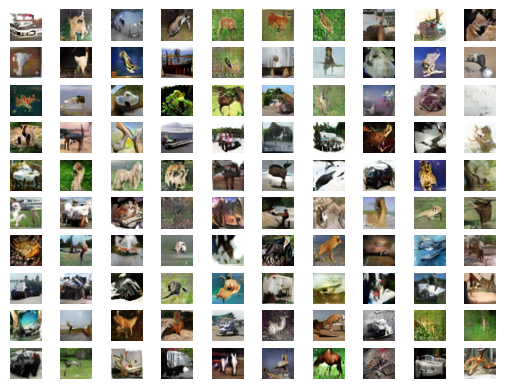

[[-0.49365101]]


In [ ]:
# Generation of 100 fake pictures
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_200.h5')
#model = load_model('generator_model_050.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)
print(generate_latent_points(1, 1))

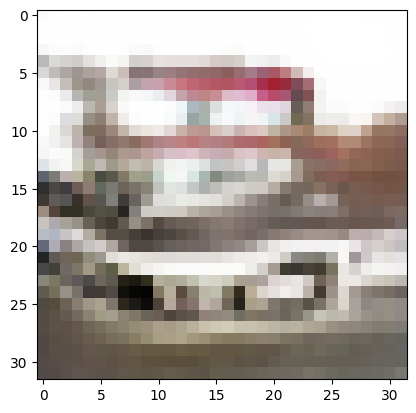

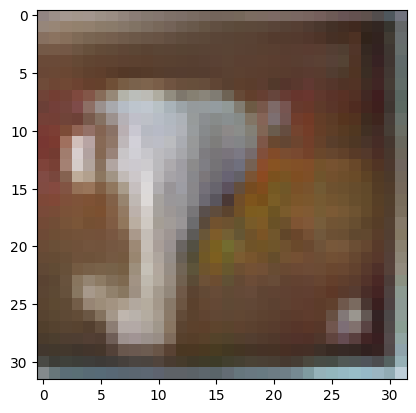

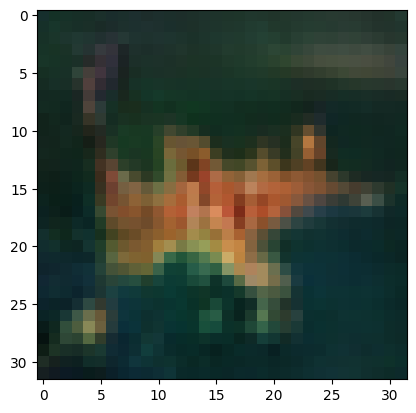

In [ ]:
#Example of plotting the first image of the first three rows, one by one
#plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()
pyplot.imshow(X[10, :, :])
pyplot.show()
pyplot.imshow(X[20, :, :])
pyplot.show()




In [ ]:

# We fit a CIFAR10 CNN classification model and save the final model to a file
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
 # load dataset
 (trainX, trainY), (testX, testY) = cifar10.load_data()
 # one hot encode target values
 trainY = to_categorical(trainY)
 testY = to_categorical(testY)
 return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

# run the test harness for evaluating a model
def run_test_harness():
 # load dataset
 trainX, trainY, testX, testY = load_dataset()
 # prepare pixel data
 trainX, testX = prep_pixels(trainX, testX)
 # define model
 model = define_model()
 # fit model
 model.fit(trainX, trainY, epochs=50, batch_size=64, verbose=1)
 # save model
 model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

Epoch 1/50
782/782 [==============================] - 8s 8ms/step - loss: 1.5705 - accuracy: 0.4274
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 1.0604 - accuracy: 0.6239
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.8542 - accuracy: 0.7002
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.7124 - accuracy: 0.7501
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.6005 - accuracy: 0.7895
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 0.5141 - accuracy: 0.8210
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 0.4420 - accuracy: 0.8428
Epoch 8/50
782/782 [==============================] - 6s 8ms/step - loss: 0.3663 - accuracy: 0.8703
Epoch 9/50
782/782 [==============================] - 6s 8ms/step - loss: 0.3235 - accuracy: 0.8840
Epoch 10/50
782/782 [==============================] - 6s 8ms/step - loss: 0.2809 - accuracy: 0.9001

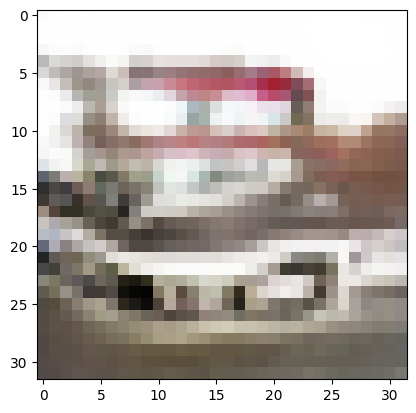

1/1 [==============================] - 0s 246ms/step
[[2.3082456e-02 9.7468412e-01 6.0884170e-10 9.1408401e-05 8.9099657e-08
  3.5414348e-07 6.1169071e-06 3.5083030e-09 5.6409655e-04 1.5714349e-03]]
1/1 [==============================] - 0s 17ms/step
Automobile


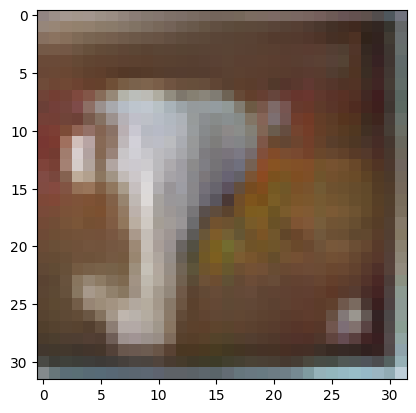

1/1 [==============================] - 0s 20ms/step
Cat


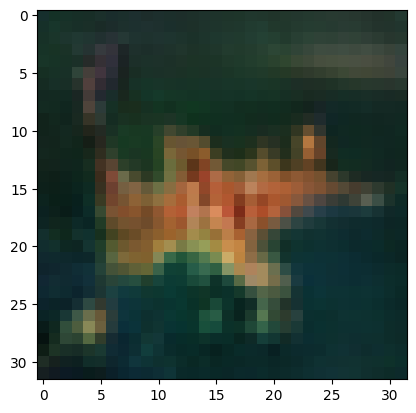

1/1 [==============================] - 0s 16ms/step
Cat


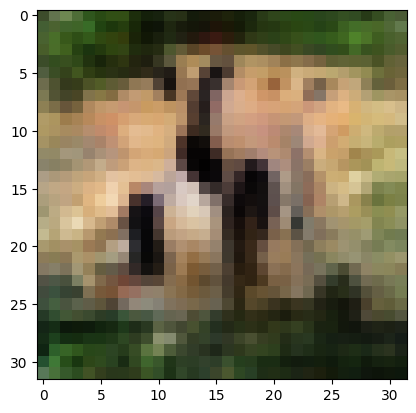

1/1 [==============================] - 0s 22ms/step
Dog


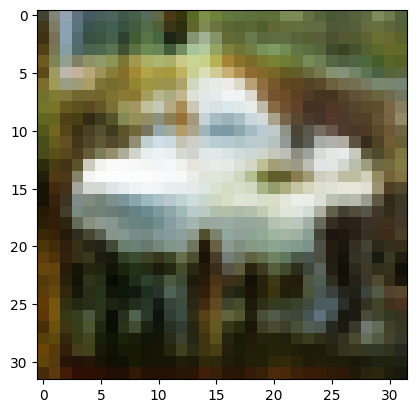

1/1 [==============================] - 0s 19ms/step
Automobile


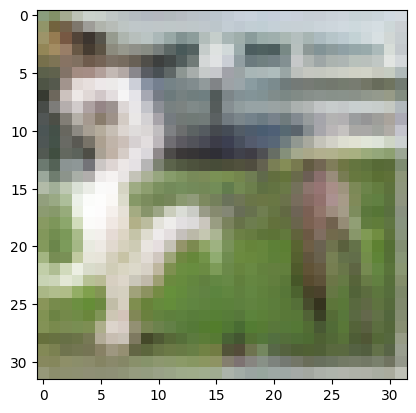

1/1 [==============================] - 0s 19ms/step
Horse


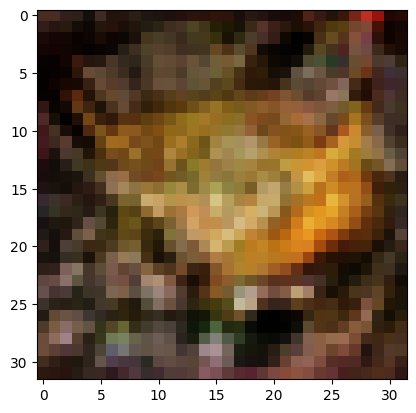

1/1 [==============================] - 0s 16ms/step
Frog


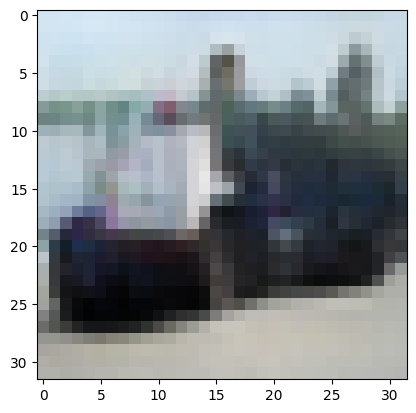

1/1 [==============================] - 0s 17ms/step
Automobile


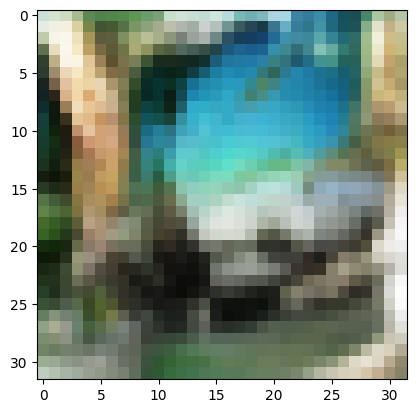

1/1 [==============================] - 0s 25ms/step
Frog


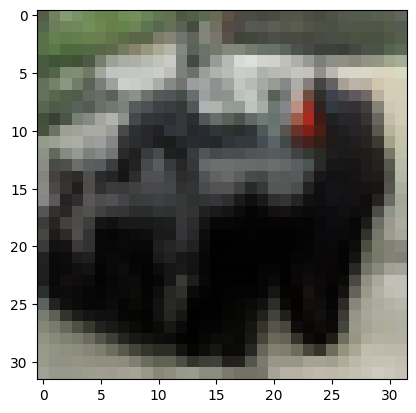

1/1 [==============================] - 0s 17ms/step
Cat


In [ ]:
#Testing the fake pictures
#We load the fitted CIFAR10 classification model and
#see what classes are predicted by the GAN generated images for the first image of the ten rows
import numpy as np
class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
cifar10_model = load_model('/content/final_model.h5')
pyplot.imshow(X[0, :, :])
pyplot.show()
#Here we show the actual predicted class values for the ten possible categories.
print(cifar10_model.predict(X[0, :, :].reshape((1,32,32,3))))
print(class_names[np.argmax(cifar10_model.predict(X[0, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[10, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[10, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[20, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[20, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[30, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[30, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[40, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[40, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[50, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[50, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[60, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[60, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[70, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[70, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[80, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[80, :, :].reshape((1,32,32,3))))])
pyplot.imshow(X[90, :, :])
pyplot.show()
print(class_names[np.argmax(cifar10_model.predict(X[90, :, :].reshape((1,32,32,3))))])


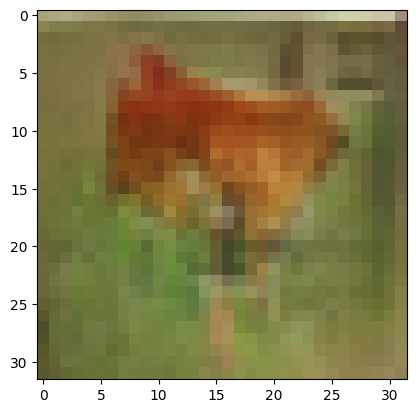

1/1 [==============================] - 0s 20ms/step
Deer
[[5.9035106e-06 4.3714222e-06 6.9067045e-03 3.7893724e-01 4.9558830e-01
  9.7756326e-02 5.0359213e-04 1.9911217e-02 1.3183788e-04 2.5442461e-04]]


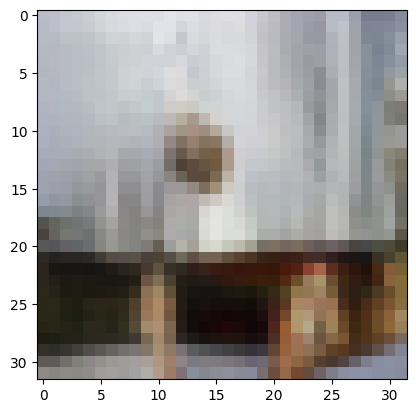

1/1 [==============================] - 0s 16ms/step
Cat
[[0.12870577 0.00442266 0.03596544 0.51586604 0.02021905 0.16200638
  0.04299919 0.02020898 0.02459197 0.04501445]]


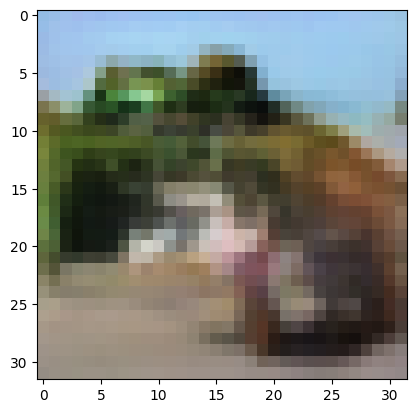

1/1 [==============================] - 0s 18ms/step
Frog
[[2.3423797e-06 9.3455354e-05 1.6406393e-05 6.0630500e-05 1.9753261e-02
  1.1014523e-02 6.9938123e-01 1.4164812e-03 1.1821094e-05 2.6824984e-01]]


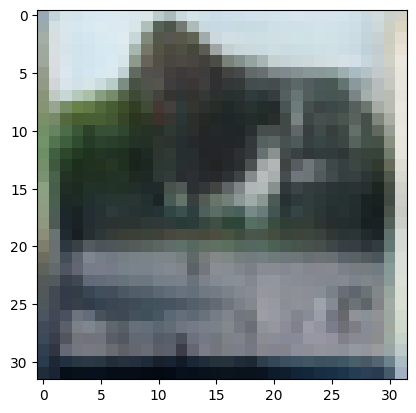

1/1 [==============================] - 0s 16ms/step
Cat
[[1.8519780e-05 6.2783256e-05 1.3711164e-03 9.8948902e-01 2.4342331e-05
  1.5814658e-06 3.3209872e-04 2.6732612e-06 3.2258299e-04 8.3752265e-03]]


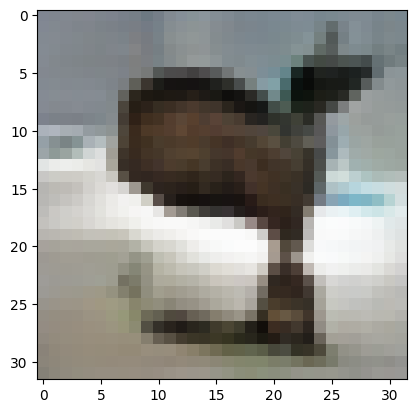

1/1 [==============================] - 0s 18ms/step
Automobile
[[2.4927172e-03 7.4415529e-01 2.4739157e-01 1.2166075e-03 1.5137141e-07
  4.5487125e-04 6.8913051e-04 4.2311597e-04 2.6601597e-07 3.1762752e-03]]


In [ ]:
# Indices of the top 5 images
top_5_indices = [5, 15, 25, 35, 45]  # Adjust these indices based on your preference

# Function to display predicted class names and actual class numerical scores
def display_prediction_info(index):
    fake_image = X[index, :, :]
    fake_image = fake_image.reshape((1, 32, 32, 3))

    # Display the fake image
    pyplot.imshow(fake_image[0])
    pyplot.show()

    # Predict the class probabilities
    predicted_probs = cifar10_model.predict(fake_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predicted_probs)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Display the predicted class name
    print(predicted_class_name)

    # Display the actual class numerical scores
    print(predicted_probs)

# Display prediction info for the top 5 images
for index in top_5_indices:
    display_prediction_info(index)

# **Question 3 **

Yes the 5 images that I selected have cvalues scores larger than 0.5


1/1 [==============================] - 0s 18ms/step
Instances of 'Deer':


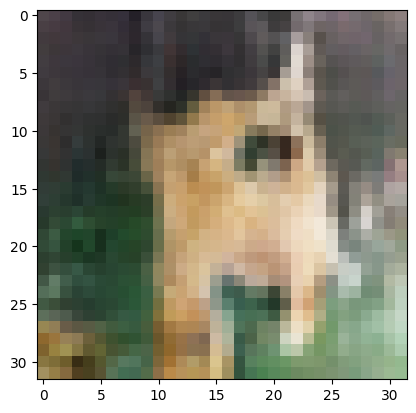

1/1 [==============================] - 0s 18ms/step
Deer
[[1.1541223e-07 3.6812089e-10 1.7298511e-03 1.2333043e-03 9.5863110e-01
  3.3667807e-02 1.8287159e-03 2.9087125e-03 4.8011538e-07 1.2571581e-08]]


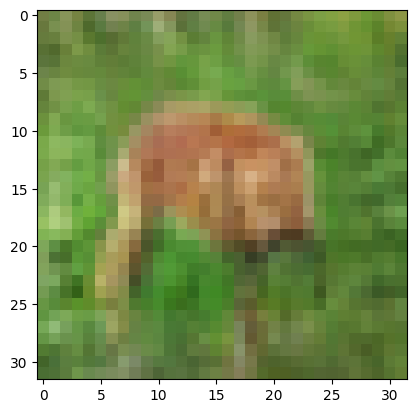

1/1 [==============================] - 0s 17ms/step
Deer
[[3.0504423e-05 1.3984089e-04 2.1550041e-03 1.5333588e-01 8.0103254e-01
  2.5438400e-02 1.2237478e-02 2.4577507e-03 3.1262354e-03 4.6434623e-05]]


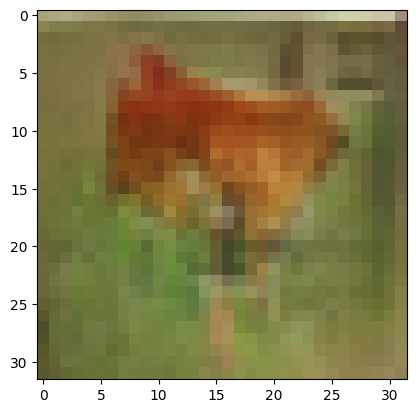

1/1 [==============================] - 0s 28ms/step
Deer
[[5.9035106e-06 4.3714222e-06 6.9067045e-03 3.7893724e-01 4.9558830e-01
  9.7756326e-02 5.0359213e-04 1.9911217e-02 1.3183788e-04 2.5442461e-04]]


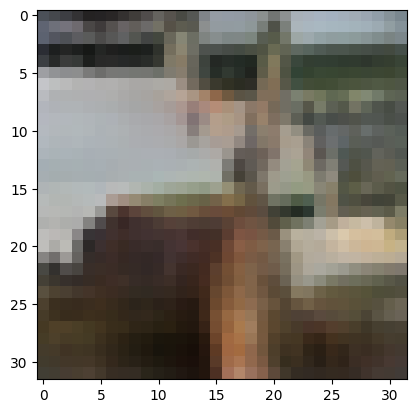

1/1 [==============================] - 0s 17ms/step
Deer
[[7.6187412e-06 1.2752092e-09 7.3374837e-04 8.8657056e-05 5.9469056e-01
  1.2236260e-04 1.4670046e-08 4.0435696e-01 4.7648221e-08 3.3917011e-10]]


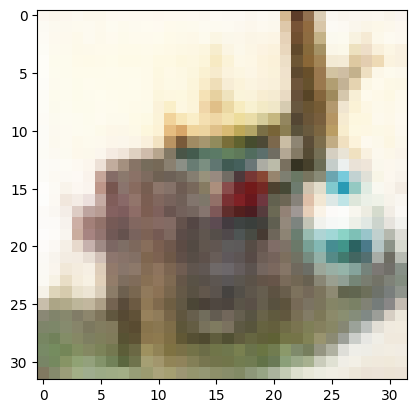

1/1 [==============================] - 0s 19ms/step
Deer
[[1.1140602e-02 5.2251730e-06 1.0715002e-05 1.0907794e-02 9.4831985e-01
  5.2183237e-05 3.7439409e-04 1.6555527e-02 1.0861586e-02 1.7719945e-03]]


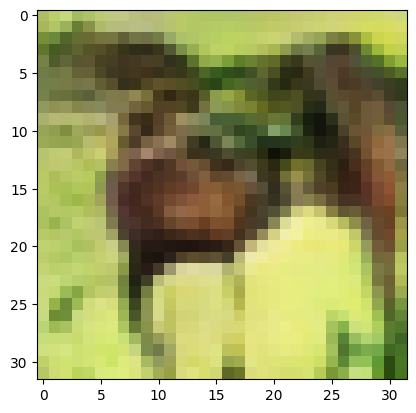

1/1 [==============================] - 0s 20ms/step
Deer
[[1.8277764e-16 4.2866342e-16 1.9729900e-09 1.3870947e-09 9.9795437e-01
  7.4208630e-09 7.5576168e-10 2.0455623e-03 1.2037468e-11 1.3967972e-18]]


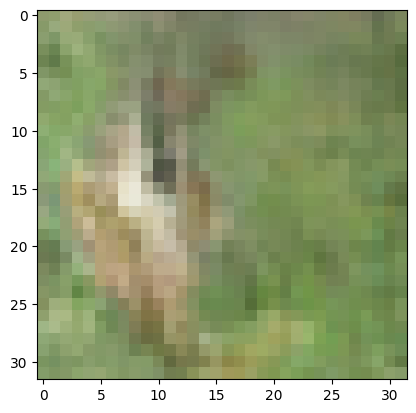

1/1 [==============================] - 0s 21ms/step
Deer
[[7.7089382e-04 8.3195213e-05 3.8009550e-02 8.4415138e-02 8.5767061e-01
  2.1251240e-03 1.5946388e-02 3.2153013e-05 9.4354560e-04 3.4231780e-06]]


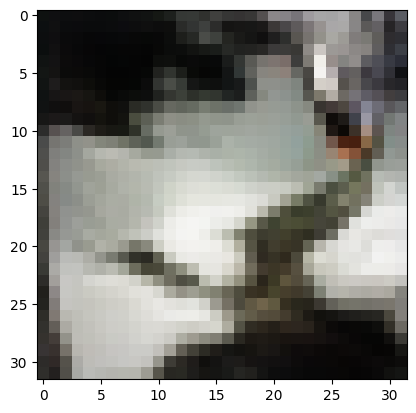

1/1 [==============================] - 0s 41ms/step
Deer
[[5.9087278e-17 1.5795323e-17 4.2748349e-10 1.6561438e-10 9.9999940e-01
  3.3522369e-16 4.0161521e-07 1.6966695e-07 3.2371346e-17 3.4745203e-22]]


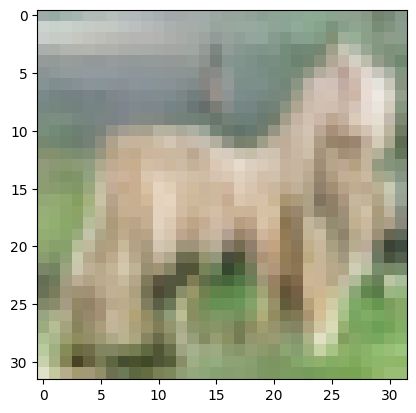

1/1 [==============================] - 0s 29ms/step
Deer
[[2.0209356e-08 1.1004152e-10 1.0117040e-07 7.6137921e-06 9.9990177e-01
  6.7502697e-05 1.5255869e-08 2.1365528e-05 1.6551123e-06 9.2224195e-10]]


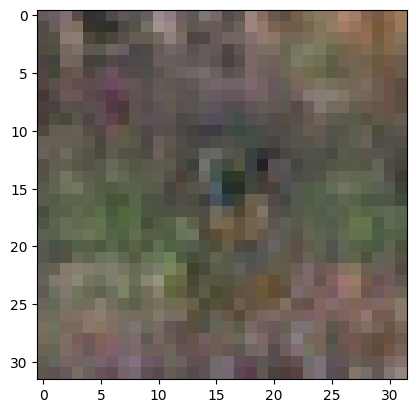

1/1 [==============================] - 0s 27ms/step
Deer
[[7.0873574e-09 1.3585727e-08 6.3851872e-03 6.6855202e-05 9.9298120e-01
  6.1694859e-06 5.6041463e-04 7.7125037e-08 6.3437213e-08 1.3486862e-09]]


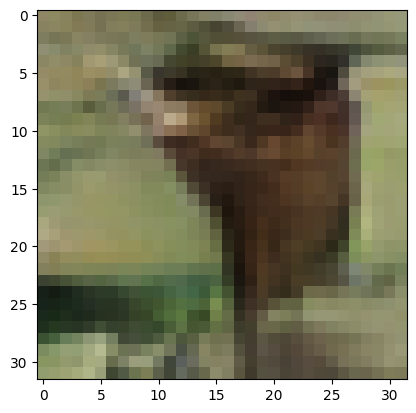

1/1 [==============================] - 0s 75ms/step
Deer
[[1.43098369e-08 1.09633372e-13 1.88696853e-04 2.88805012e-07
  9.99708354e-01 6.42433179e-07 7.96067390e-09 1.02047044e-04
  9.89658550e-13 2.86008023e-12]]


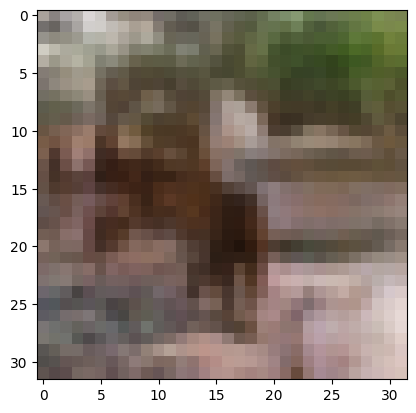

1/1 [==============================] - 0s 49ms/step
Deer
[[1.7542445e-07 2.2634471e-10 8.0648204e-04 1.5380352e-03 9.5798475e-01
  2.1980621e-03 8.7181788e-06 3.7463792e-02 3.0382336e-11 7.4647062e-09]]


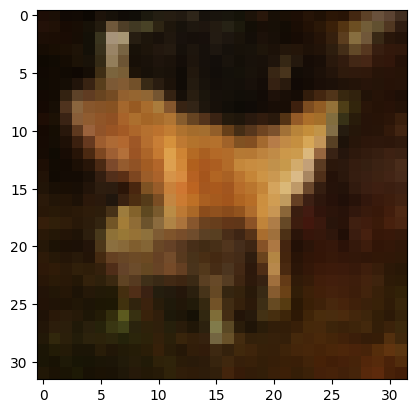

1/1 [==============================] - 0s 19ms/step
Deer
[[3.3901513e-04 9.1408103e-10 1.6128537e-04 6.8763890e-03 9.9002773e-01
  2.5288211e-03 2.5972261e-07 6.6057008e-05 4.8419486e-07 7.5449735e-09]]


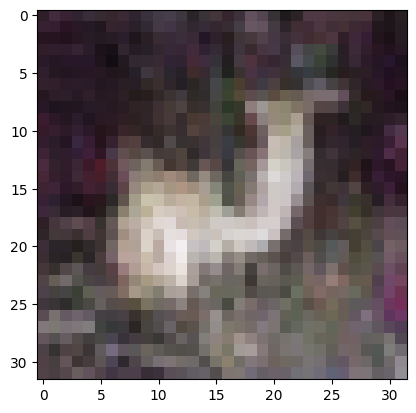

1/1 [==============================] - 0s 25ms/step
Deer
[[9.8027012e-06 6.3670573e-06 3.7199303e-03 5.7744514e-02 8.5256624e-01
  3.5243181e-03 2.5176598e-02 5.7015136e-02 2.1823631e-04 1.8812205e-05]]


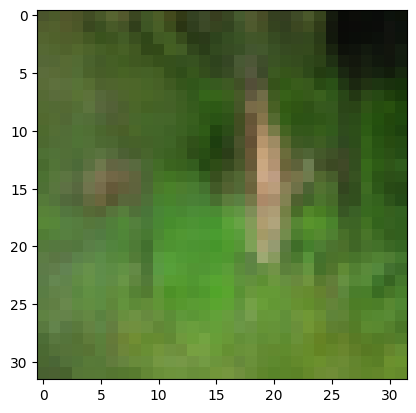

1/1 [==============================] - 0s 29ms/step
Deer
[[1.0540123e-03 2.4878298e-05 3.7933171e-03 3.6090532e-01 4.1336089e-01
  8.8253728e-05 2.1432857e-01 7.3951116e-04 4.2577442e-03 1.4475038e-03]]


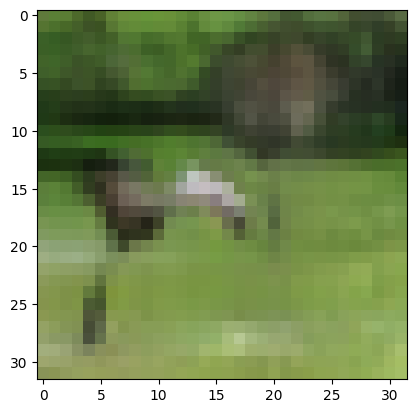

1/1 [==============================] - 0s 32ms/step
Deer
[[1.6808053e-03 1.9087885e-04 3.7273411e-02 1.4625809e-01 8.0144846e-01
  6.9138734e-04 9.4218794e-03 3.6727922e-04 2.2045719e-03 4.6322984e-04]]
Instances of 'Bird':


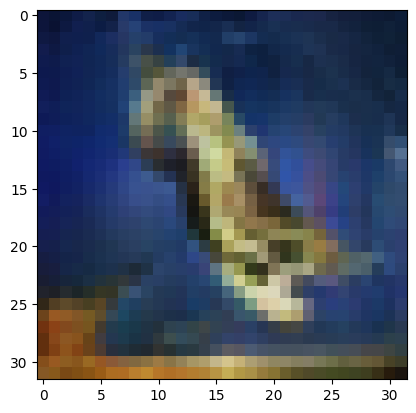

1/1 [==============================] - 0s 25ms/step
Bird
[[4.4067139e-07 1.0287885e-11 9.9988794e-01 1.3601559e-06 1.0329286e-05
  8.6368503e-09 9.7106727e-05 2.2864608e-09 2.8682214e-06 4.2175381e-11]]


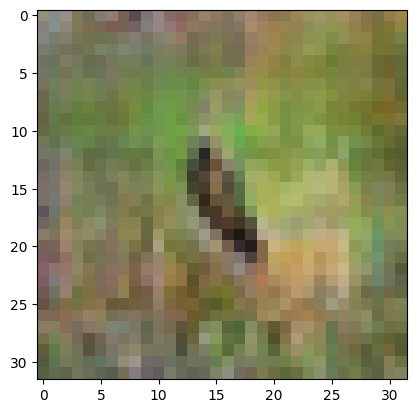

1/1 [==============================] - 0s 28ms/step
Bird
[[2.9048826e-07 4.6554291e-08 9.9903333e-01 1.0782975e-05 1.4261176e-05
  9.4822013e-07 9.3662448e-04 1.9623185e-09 3.6744368e-06 1.6130082e-09]]


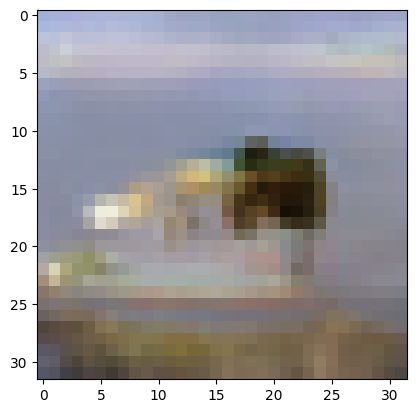

1/1 [==============================] - 0s 31ms/step
Bird
[[5.5796874e-05 9.9250276e-05 6.1045349e-01 4.7836467e-04 4.8384325e-05
  1.2759297e-04 1.8977884e-05 4.3994851e-07 3.8862354e-01 9.4145777e-05]]


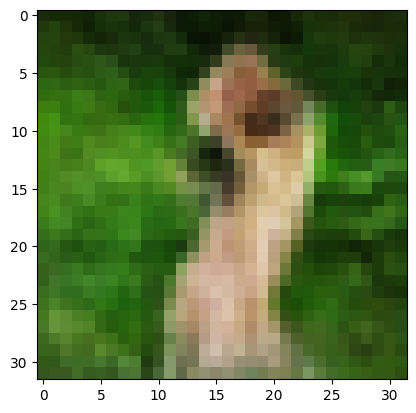

1/1 [==============================] - 0s 31ms/step
Bird
[[2.5065946e-13 1.0200353e-13 9.5725071e-01 3.3707965e-05 2.6319660e-06
  4.2712927e-02 3.3642027e-09 3.3572753e-08 4.2411324e-10 3.2209313e-10]]


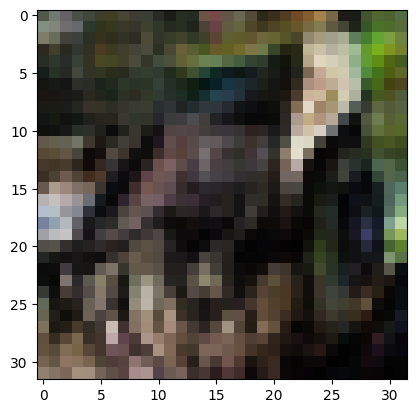

1/1 [==============================] - 0s 31ms/step
Bird
[[9.4214387e-02 2.7139290e-06 8.5303569e-01 4.4723171e-07 2.1297580e-03
  1.1112516e-07 5.0405383e-02 6.4211439e-05 2.7335105e-07 1.4707484e-04]]


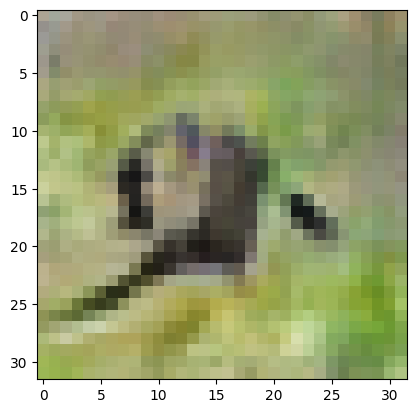

1/1 [==============================] - 0s 29ms/step
Bird
[[3.4418266e-05 1.0553739e-11 9.9597317e-01 3.1431394e-03 1.1384433e-09
  2.3888482e-04 6.0562260e-04 4.7820063e-06 1.1121769e-10 3.0743731e-08]]


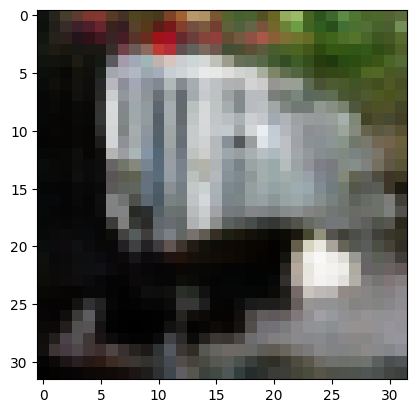

1/1 [==============================] - 0s 26ms/step
Bird
[[1.9010091e-04 6.3520320e-02 8.9009935e-01 7.8134943e-04 1.0384287e-04
  3.4658271e-03 1.1520763e-02 1.5570059e-04 1.7445182e-02 1.2717587e-02]]
1/1 [==============================] - 0s 16ms/step

Statistics for 'Deer':
Minimum class values: [5.9087278e-17 1.5795323e-17 4.2748349e-10 1.6561438e-10 4.1336089e-01
 3.3522369e-16 7.5576168e-10 7.7125037e-08 3.2371346e-17 3.4745203e-22]
Average class values: [9.3996816e-04 2.8423339e-05 6.3671237e-03 7.5144701e-02 8.5386670e-01
 1.0516710e-02 1.7524216e-02 3.4002710e-02 1.3591554e-03 2.5036582e-04]
Maximum class values: [1.1140602e-02 1.9087885e-04 3.8009550e-02 3.7893724e-01 9.9999940e-01
 9.7756326e-02 2.1432857e-01 4.0435696e-01 1.0861586e-02 1.7719945e-03]
1/1 [==============================] - 0s 20ms/step

Statistics for 'Bird':
Minimum class values: [2.5065946e-13 1.0200353e-13 6.1045349e-01 4.4723171e-07 1.1384433e-09
 8.6368503e-09 3.3642027e-09 1.9623185e-09 1.1121769e-10 

In [ ]:
deer_indices = [i for i in range(100) if class_names[np.argmax(cifar10_model.predict(X[i, :, :].reshape((1, 32, 32, 3))))] == 'Deer']
bird_indices = [i for i in range(100) if class_names[np.argmax(cifar10_model.predict(X[i, :, :].reshape((1, 32, 32, 3))))] == 'Bird']
print("Instances of 'Deer':")
for index in deer_indices:
    display_prediction_info(index)

print("Instances of 'Bird':")
for index in bird_indices:
    display_prediction_info(index)

# Compute and display statistics for 'Deer'
deer_class_values = [cifar10_model.predict(X[i, :, :].reshape((1, 32, 32, 3)))[0] for i in deer_indices]
deer_class_values = np.array(deer_class_values)
print("\nStatistics for 'Deer':")
print("Minimum class values:", np.min(deer_class_values, axis=0))
print("Average class values:", np.mean(deer_class_values, axis=0))
print("Maximum class values:", np.max(deer_class_values, axis=0))

# Compute and display statistics for 'Bird'
bird_class_values = [cifar10_model.predict(X[i, :, :].reshape((1, 32, 32, 3)))[0] for i in bird_indices]
bird_class_values = np.array(bird_class_values)
print("\nStatistics for 'Bird':")
print("Minimum class values:", np.min(bird_class_values, axis=0))
print("Average class values:", np.mean(bird_class_values, axis=0))
print("Maximum class values:", np.max(bird_class_values, axis=0))

# **Output for 100 instanaces for Bird and deer **

Statistics for 'Deer':
Minimum class values: [5.9087278e-17 1.5795323e-17 4.2748349e-10 1.6561438e-10 4.1336089e-01
 3.3522369e-16 7.5576168e-10 7.7125037e-08 3.2371346e-17 3.4745203e-22]
Average class values: [9.3996816e-04 2.8423339e-05 6.3671237e-03 7.5144701e-02 8.5386670e-01
 1.0516710e-02 1.7524216e-02 3.4002710e-02 1.3591554e-03 2.5036582e-04]
Maximum class values: [1.1140602e-02 1.9087885e-04 3.8009550e-02 3.7893724e-01 9.9999940e-01
 9.7756326e-02 2.1432857e-01 4.0435696e-01 1.0861586e-02 1.7719945e-03]


 Statistics for 'Bird':
Minimum class values: [2.5065946e-13 1.0200353e-13 6.1045349e-01 4.4723171e-07 1.1384433e-09
 8.6368503e-09 3.3642027e-09 1.9623185e-09 1.1121769e-10 4.2175381e-11]
Average class values: [1.3499348e-02 9.0889046e-03 9.0081918e-01 6.3559314e-04 3.2988700e-04
 6.6494714e-03 9.0834973e-03 3.2167398e-05 5.8010790e-02 1.8512629e-03]
Maximum class values: [9.4214387e-02 6.3520320e-02 9.9988794e-01 3.1431394e-03 2.1297580e-03
 4.2712927e-02 5.0405383e-02 1.5570059e-04 3.8862354e-01 1.2717587e-02]


4/4 [==============================] - 1s 91ms/step
Instances with the highest average class values:


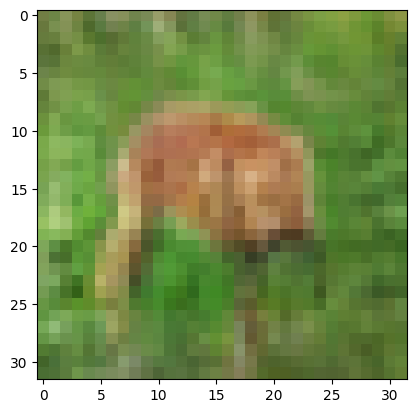

1/1 [==============================] - 0s 51ms/step
Deer
[[3.0504423e-05 1.3984089e-04 2.1550041e-03 1.5333588e-01 8.0103254e-01
  2.5438400e-02 1.2237478e-02 2.4577507e-03 3.1262354e-03 4.6434623e-05]]


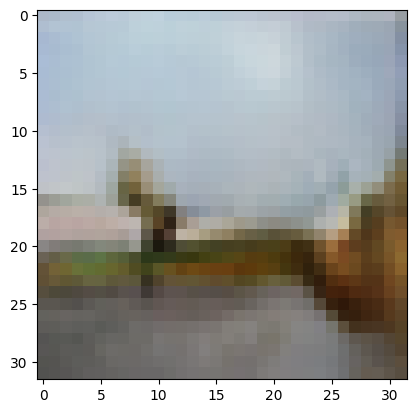

1/1 [==============================] - 0s 30ms/step
Airplane
[[9.9924409e-01 4.6757151e-08 7.8267694e-05 1.1841293e-05 2.6254338e-04
  1.4999418e-07 1.9550620e-07 2.7645953e-04 1.2644463e-04 6.8361771e-08]]


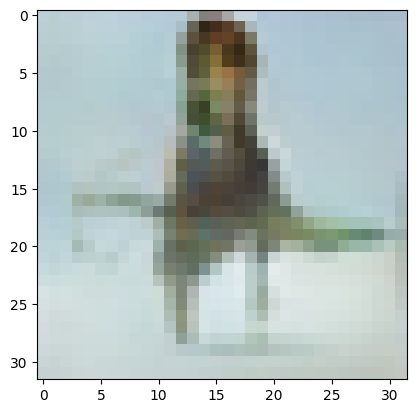

1/1 [==============================] - 0s 55ms/step
Frog
[[4.8051914e-03 2.3517497e-08 1.6709286e-05 3.6173532e-04 4.1682004e-08
  3.9228648e-06 9.9481225e-01 1.4539120e-08 2.6076419e-08 2.4942415e-07]]


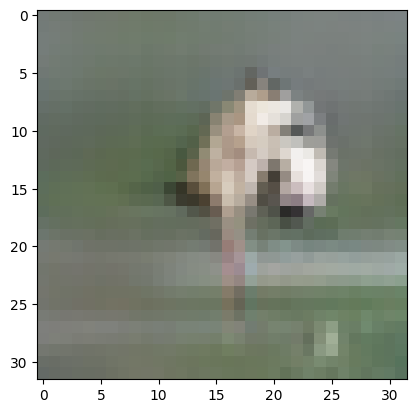

1/1 [==============================] - 0s 17ms/step
Airplane
[[4.70795095e-01 1.53592834e-03 4.09342116e-03 1.95143293e-04
  9.99187771e-03 3.93620878e-01 3.84762720e-03 3.82722064e-04
  5.71887009e-03 1.09818436e-01]]


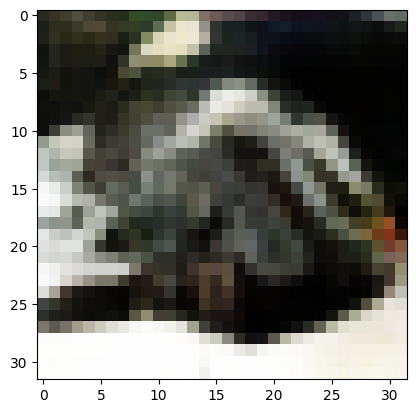

1/1 [==============================] - 0s 17ms/step
Cat
[[3.38573353e-12 5.26729149e-09 7.69150461e-07 9.98542786e-01
  1.46746282e-10 3.35462573e-06 1.45317509e-03 3.77735586e-11
  1.21997009e-12 1.43537526e-11]]


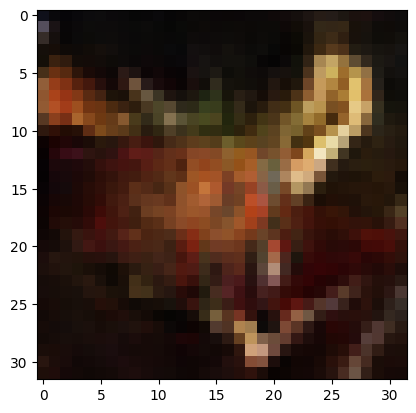

1/1 [==============================] - 0s 30ms/step
Frog
[[2.4533625e-11 1.7555399e-12 5.9360222e-10 2.0502096e-03 3.4885331e-06
  5.4076857e-14 9.9794632e-01 9.8220802e-17 5.5470837e-15 9.0784817e-21]]


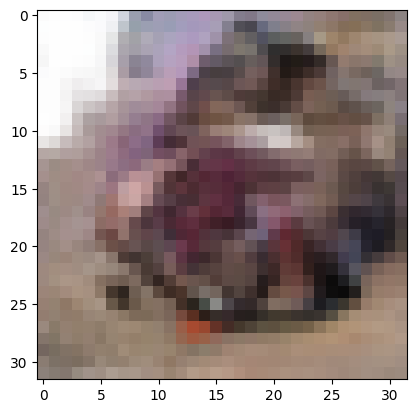

1/1 [==============================] - 0s 23ms/step
Automobile
[[8.0665290e-05 5.7919025e-01 6.1249110e-04 2.1596844e-01 2.4108151e-04
  6.9936223e-02 1.5918823e-02 1.1630152e-01 7.2121312e-04 1.0293097e-03]]


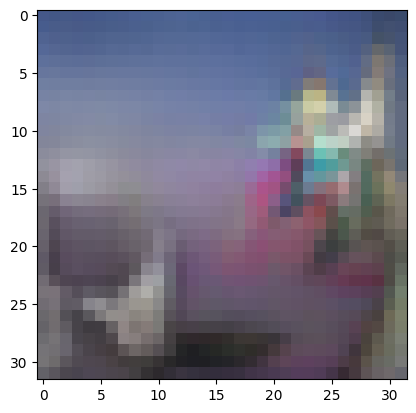

1/1 [==============================] - 0s 31ms/step
Ship
[[5.9111092e-02 3.8385475e-05 4.8438720e-02 1.9146021e-02 4.8407964e-02
  2.5053447e-04 2.1269510e-02 2.6097205e-05 8.0294806e-01 3.6367448e-04]]


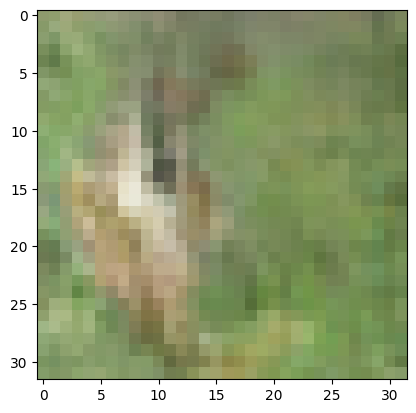

1/1 [==============================] - 0s 30ms/step
Deer
[[7.7089382e-04 8.3195213e-05 3.8009550e-02 8.4415138e-02 8.5767061e-01
  2.1251240e-03 1.5946388e-02 3.2153013e-05 9.4354560e-04 3.4231780e-06]]


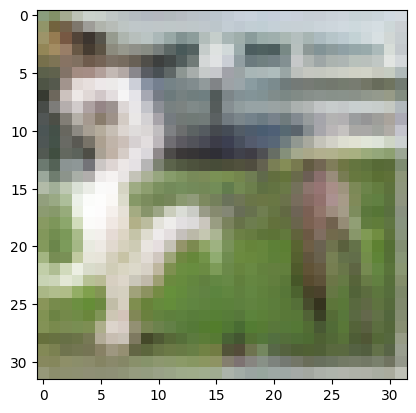

1/1 [==============================] - 0s 31ms/step
Horse
[[4.0586156e-06 8.6368964e-06 1.4759573e-05 8.3560168e-05 1.0163527e-04
  1.6812899e-03 6.9087586e-10 9.9810445e-01 4.8292080e-08 1.5372760e-06]]
1/1 [==============================] - 0s 218ms/step

Statistics for instances with the highest average class values:
Minimum class values: [3.3857528e-12 1.7554664e-12 5.9361471e-10 1.1841529e-05 1.4674852e-10
 5.4076240e-14 6.9086925e-10 9.8219307e-17 5.5468935e-15 9.0782402e-21]
Average class values: [0.15348296 0.05809956 0.00934189 0.1474109  0.17177127 0.04930736
 0.20634314 0.11175827 0.08135864 0.01112607]
Maximum class values: [0.9992441  0.57918954 0.04843779 0.9985428  0.8576718  0.393635
 0.9979463  0.99810445 0.8029501  0.10981598]


In [ ]:
average_class_values = np.mean(cifar10_model.predict(X), axis=1)

top_indices = np.argsort(-average_class_values, axis=0)[:10]

print("Instances with the highest average class values:")
for index in top_indices:
    display_prediction_info(index)

# Compute and display statistics for instances with the highest average class values
top_class_values = cifar10_model.predict(X[top_indices, :, :, :])
print("\nStatistics for instances with the highest average class values:")
print("Minimum class values:", np.min(top_class_values, axis=0))
print("Average class values:", np.mean(top_class_values, axis=0))
print("Maximum class values:", np.max(top_class_values, axis=0))

# **Output for the highest average class value relative to all other classes**

Statistics for instances with the highest average class values:
Minimum class values: [3.3857528e-12 1.7554664e-12 5.9361471e-10 1.1841529e-05 1.4674852e-10
 5.4076240e-14 6.9086925e-10 9.8219307e-17 5.5468935e-15 9.0782402e-21]
Average class values: [0.15348296 0.05809956 0.00934189 0.1474109  0.17177127 0.04930736
 0.20634314 0.11175827 0.08135864 0.01112607]
Maximum class values: [0.9992441  0.57918954 0.04843779 0.9985428  0.8576718  0.393635
 0.9979463  0.99810445 0.8029501  0.10981598]
